In [3]:
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import os
import sys
import torch
import time
import seaborn as sns
from sklearn.metrics.pairwise import linear_kernel
from scipy.linalg import svd

from sklearn.metrics.pairwise import linear_kernel

# X 和 Y 的维度可以不一样
sys.path.insert(0,os.path.abspath('/notebooks/4901_revisit_cdtran'))
sys.path.insert(0,os.path.abspath('/notebooks/pytorchtimseries'))
from tqdm.notebook import tqdm


def xy_plot(x, y, pred_y, title=None, y_label=None):
    with plt.style.context(['ieee', 'notebook']):

        fig, ax = plt.subplots()
        
        x_ticks = np.arange(len(x))
        y_ticks = np.arange(len(x), len(x)+len(y))
        
        # 设置边框粗度
        for spine in ax.spines.values():
            spine.set_linewidth(2)  # 设置边框粗度为2

        
        ax.plot(x_ticks, x, label='lookback', linewidth=3)
        ax.plot(y_ticks, y, label='ground_truth', linewidth=3)
        ax.plot(y_ticks, pred_y, label='prediction', linewidth=3)
    if y_label: plt.ylabel(y_label)
    if title: plt.title(title)
    plt.legend()
    
# X 和 Y 的维度可以不一样
# K = linear_kernel(X, X)  # K: n x n
# L = linear_kernel(Y, Y)  # L: n x n

def center_kernel(K):
    n = K.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    return H @ K @ H

def compute_cka(X, Y):
    K = linear_kernel(X, X)
    L = linear_kernel(Y, Y)
    
    K_c = center_kernel(K)
    L_c = center_kernel(L)
    
    hsic = np.trace(K_c @ L_c)
    norm_k = np.trace(K_c @ K_c)
    norm_l = np.trace(L_c @ L_c)
    
    return hsic / np.sqrt(norm_k * norm_l)

def standardize(X):
    mean_vals = X.mean(axis=1, keepdims=True)
    std_vals = X.std(axis=1, keepdims=True)
    return (X - mean_vals) / (std_vals + 1e-8)  # 避免除以零


In [411]:

def center_kernel(K):
    n = K.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    return H @ K @ H

def compute_cka(X, Y):
    K = linear_kernel(X, X)
    L = linear_kernel(Y, Y)
    
    K_c = center_kernel(K)
    L_c = center_kernel(L)
    
    hsic = np.trace(K_c @ L_c)
    norm_k = np.trace(K_c @ K_c)
    norm_l = np.trace(L_c @ L_c)
    
    return hsic / np.sqrt(norm_k * norm_l)

def standardize(X):
    mean_vals = X.mean(axis=1, keepdims=True)
    std_vals = X.std(axis=1, keepdims=True)
    return (X - mean_vals) / (std_vals + 1e-8)  # 避免除以零

In [7]:
from src.experiments.CiDPG import CiDPGForecast
dataset = "ExchangeRate"
exp = CiDPGForecast(dataset_type=dataset, windows=336, horizon=1, pred_len=720, data_path='/notebooks/pytorchtimseries/data', save_dir='/notebooks/4901_revisit_cdtran/results', device='cuda:0')
exp._setup_run(1)
exp._resume_run(1)

v = 5
b = 0
i = 0
batch_x, batch_y, origin_x, origin_y, batch_x_date_enc, batch_y_date_enc = map(lambda x: torch.tensor(x).to(exp.device).unsqueeze(0).float(),  exp.dataloader.test_loader.dataset[i])
pred_y, true_y  = exp._process_one_batch(batch_x, batch_y, batch_x_date_enc, batch_y_date_enc)


# batch_x, batch_y, origin_x, origin_y, batch_x_date_enc, batch_y_date_enc = map(lambda x: x.to(exp.device).float(), next(iter(exp.test_loader)))
pred_y, true_y  = exp._process_one_batch(batch_x, batch_y, batch_x_date_enc, batch_y_date_enc)
plot_pred_y = pred_y[b, :, v].cpu().detach().numpy()


Using downloaded and verified file: /notebooks/pytorchtimseries/data/ExchangeRate/exchange_rate.csv
train steps: 4256
val steps: 798
test steps: 41
tensor([128, 182, 238, 292, 348, 402, 458, 512], dtype=torch.int32)
self.t_index [95, 143, 191, 239, 287, 335, 383]
resuming from /notebooks/4901_revisit_cdtran/results/runs/CiDPG/ExchangeRate/w336h1s720/b5d8417215bf20d2f9e7ac6b5f0691fd/run_checkpoint.pth


In [8]:
vi = 0
plot_x = batch_x[b, :, vi].cpu().detach().numpy()
plot_y = batch_y[b, :, vi].cpu().detach().numpy()
plot_pred_y = pred_y[b, :, vi].cpu().detach().numpy()




In [79]:
torch.nn.functional.pad(p, (0, 3))

torch.Size([8, 185])

In [97]:

inp = exp.model.prevs[0][0].detach().cpu().numpy()
target_length = exp.model.prevs[-1][0].shape[1]
# inps = [ np.pad(p[0].detach().cpu().numpy(), (target_length - p[0].detach().cpu().numpy().shape[1], 0), mode='constant') for p in  exp.model.prevs ]
# inps = np.array([torch.nn.functional.pad(p[0], (0, target_length - p[0].shape[1])).cpu().detach().numpy() for p in  exp.model.prevs ])
inps = [p[0].cpu().detach().numpy() for p in  exp.model.prevs ]
# np.pad(data, (0, target_length - len(data)), mode='constant', constant_values=padding_value)


In [87]:
inps.shape

(7, 8, 512)

In [77]:
p = exp.model.prevs[0][0]

In [84]:
inps[0].shape

torch.Size([8, 512])

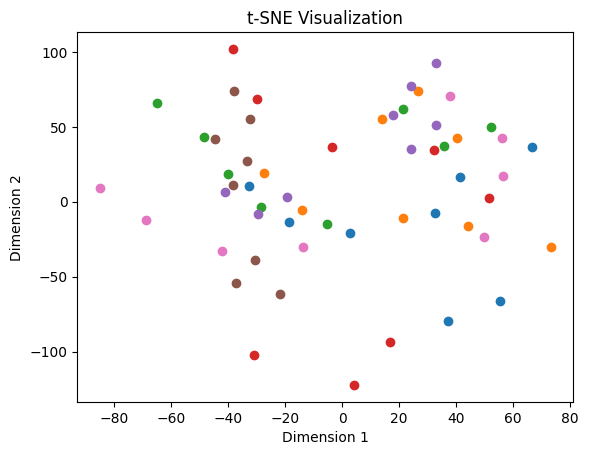

In [100]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
tsne = TSNE(n_components=2, random_state=42,perplexity=3)


for i in range(len(inps)):
    low_dim_data = tsne.fit_transform(inps[i])
    plt.scatter(low_dim_data[:, 0], low_dim_data[:, 1])
plt.title('t-SNE Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

## PEMS07

In [4]:
from src.experiments.shortterm.PAN import PANForecast
dataset = "PEMS07"
exp = PANForecast(dataset_type=dataset, d_c=256, d_patch=128, patch_len=48, stride=24, windows=96, horizon=1, pred_len=12, data_path='/notebooks/4901_revisit_cdtran/data', save_dir='/notebooks/4901_revisit_cdtran/results', device='cuda:0')
exp._setup_run(1)
exp._resume_run(1)

i = 1020
b = 0
v = 580 #b500
batch_x, batch_y, origin_x, origin_y, batch_x_date_enc, batch_y_date_enc = map(lambda x: torch.tensor(x).to(exp.device).unsqueeze(0).float(),  exp.dataloader.test_loader.dataset[i])
pred_y, true_y  = exp._process_one_batch(batch_x, batch_y, batch_x_date_enc, batch_y_date_enc)


# batch_x, batch_y, origin_x, origin_y, batch_x_date_enc, batch_y_date_enc = map(lambda x: x.to(exp.device).float(), next(iter(exp.test_loader)))
pred_y, true_y  = exp._process_one_batch(batch_x, batch_y, batch_x_date_enc, batch_y_date_enc)
plot_pred_y = pred_y[b, :, v].cpu().detach().numpy()


train steps: 19649
val steps: 5633
test steps: 2813


/root/anaconda3/envs/testpyt/lib/python3.8/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/root/anaconda3/envs/testpyt/lib/python3.8/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


tensor([128, 224, 320, 416, 512], dtype=torch.int32)
4
self.t_index [47, 71, 95, 119]
not raw_info..
resuming from /notebooks/4901_revisit_cdtran/results/runs/PAN/PEMS07/w96h1s12/2c6f9cf57c9ae858df658957f2f7046a/run_checkpoint.pth


/notebooks/pytorchtimseries/torch_timeseries/experiments/forecast.py:378: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(run_checkpoint_filepath, map

In [5]:

plot_x = batch_x[b, :, v].cpu().detach().numpy()
plot_y = batch_y[b, :, v].cpu().detach().numpy()
plot_pred_y = pred_y[b, :, v].cpu().detach().numpy()


x_ticks = np.arange(len(plot_x))
y_ticks = np.arange(len(plot_x), len(plot_x)+len(plot_y))

# xy_plot(plot_x, plot_y, plot_pred_y, 'PEMS07', 'PAN')

# plt.show()


### TSNE

In [387]:

inp = exp.model.prevs[0][0].detach().cpu().numpy()
target_length = exp.model.prevs[-1][0].shape[1]
# inps = [ np.pad(p[0].detach().cpu().numpy(), (target_length - p[0].detach().cpu().numpy().shape[1], 0), mode='constant') for p in  exp.model.prevs ]
# inps = np.array([torch.nn.functional.pad(p[0], (0, target_length - p[0].shape[1])).cpu().detach().numpy() for p in  exp.model.prevs ])
inps = [p[0].cpu().detach().numpy() for p in  exp.model.prevs ]
# np.pad(data, (0, target_length - len(data)), mode='constant', constant_values=padding_value)


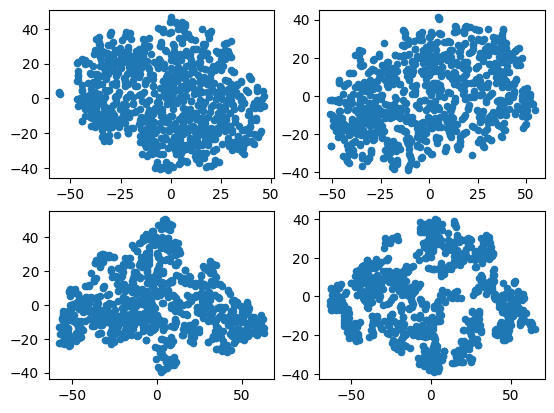

In [392]:

fig, axs = plt.subplots(2, 2)
# fig.set_size_inches(15, 15)
perplexity = 16
for i in range(0, 2):
    tsne = TSNE(n_components=2, random_state=42,perplexity=perplexity)
    low_dim_data = tsne.fit_transform(inps[i])
    axs[0, i].scatter(low_dim_data[:, 0], low_dim_data[:, 1], s=20)

for i in range(0, 2):
    tsne = TSNE(n_components=2, random_state=42,perplexity=perplexity)
    low_dim_data = tsne.fit_transform(inps[i+2])
    axs[1, i].scatter(low_dim_data[:, 0], low_dim_data[:, 1], s=20)


### TSNE-sapraete

Text(0.5, 1.0, 'Layer 4')

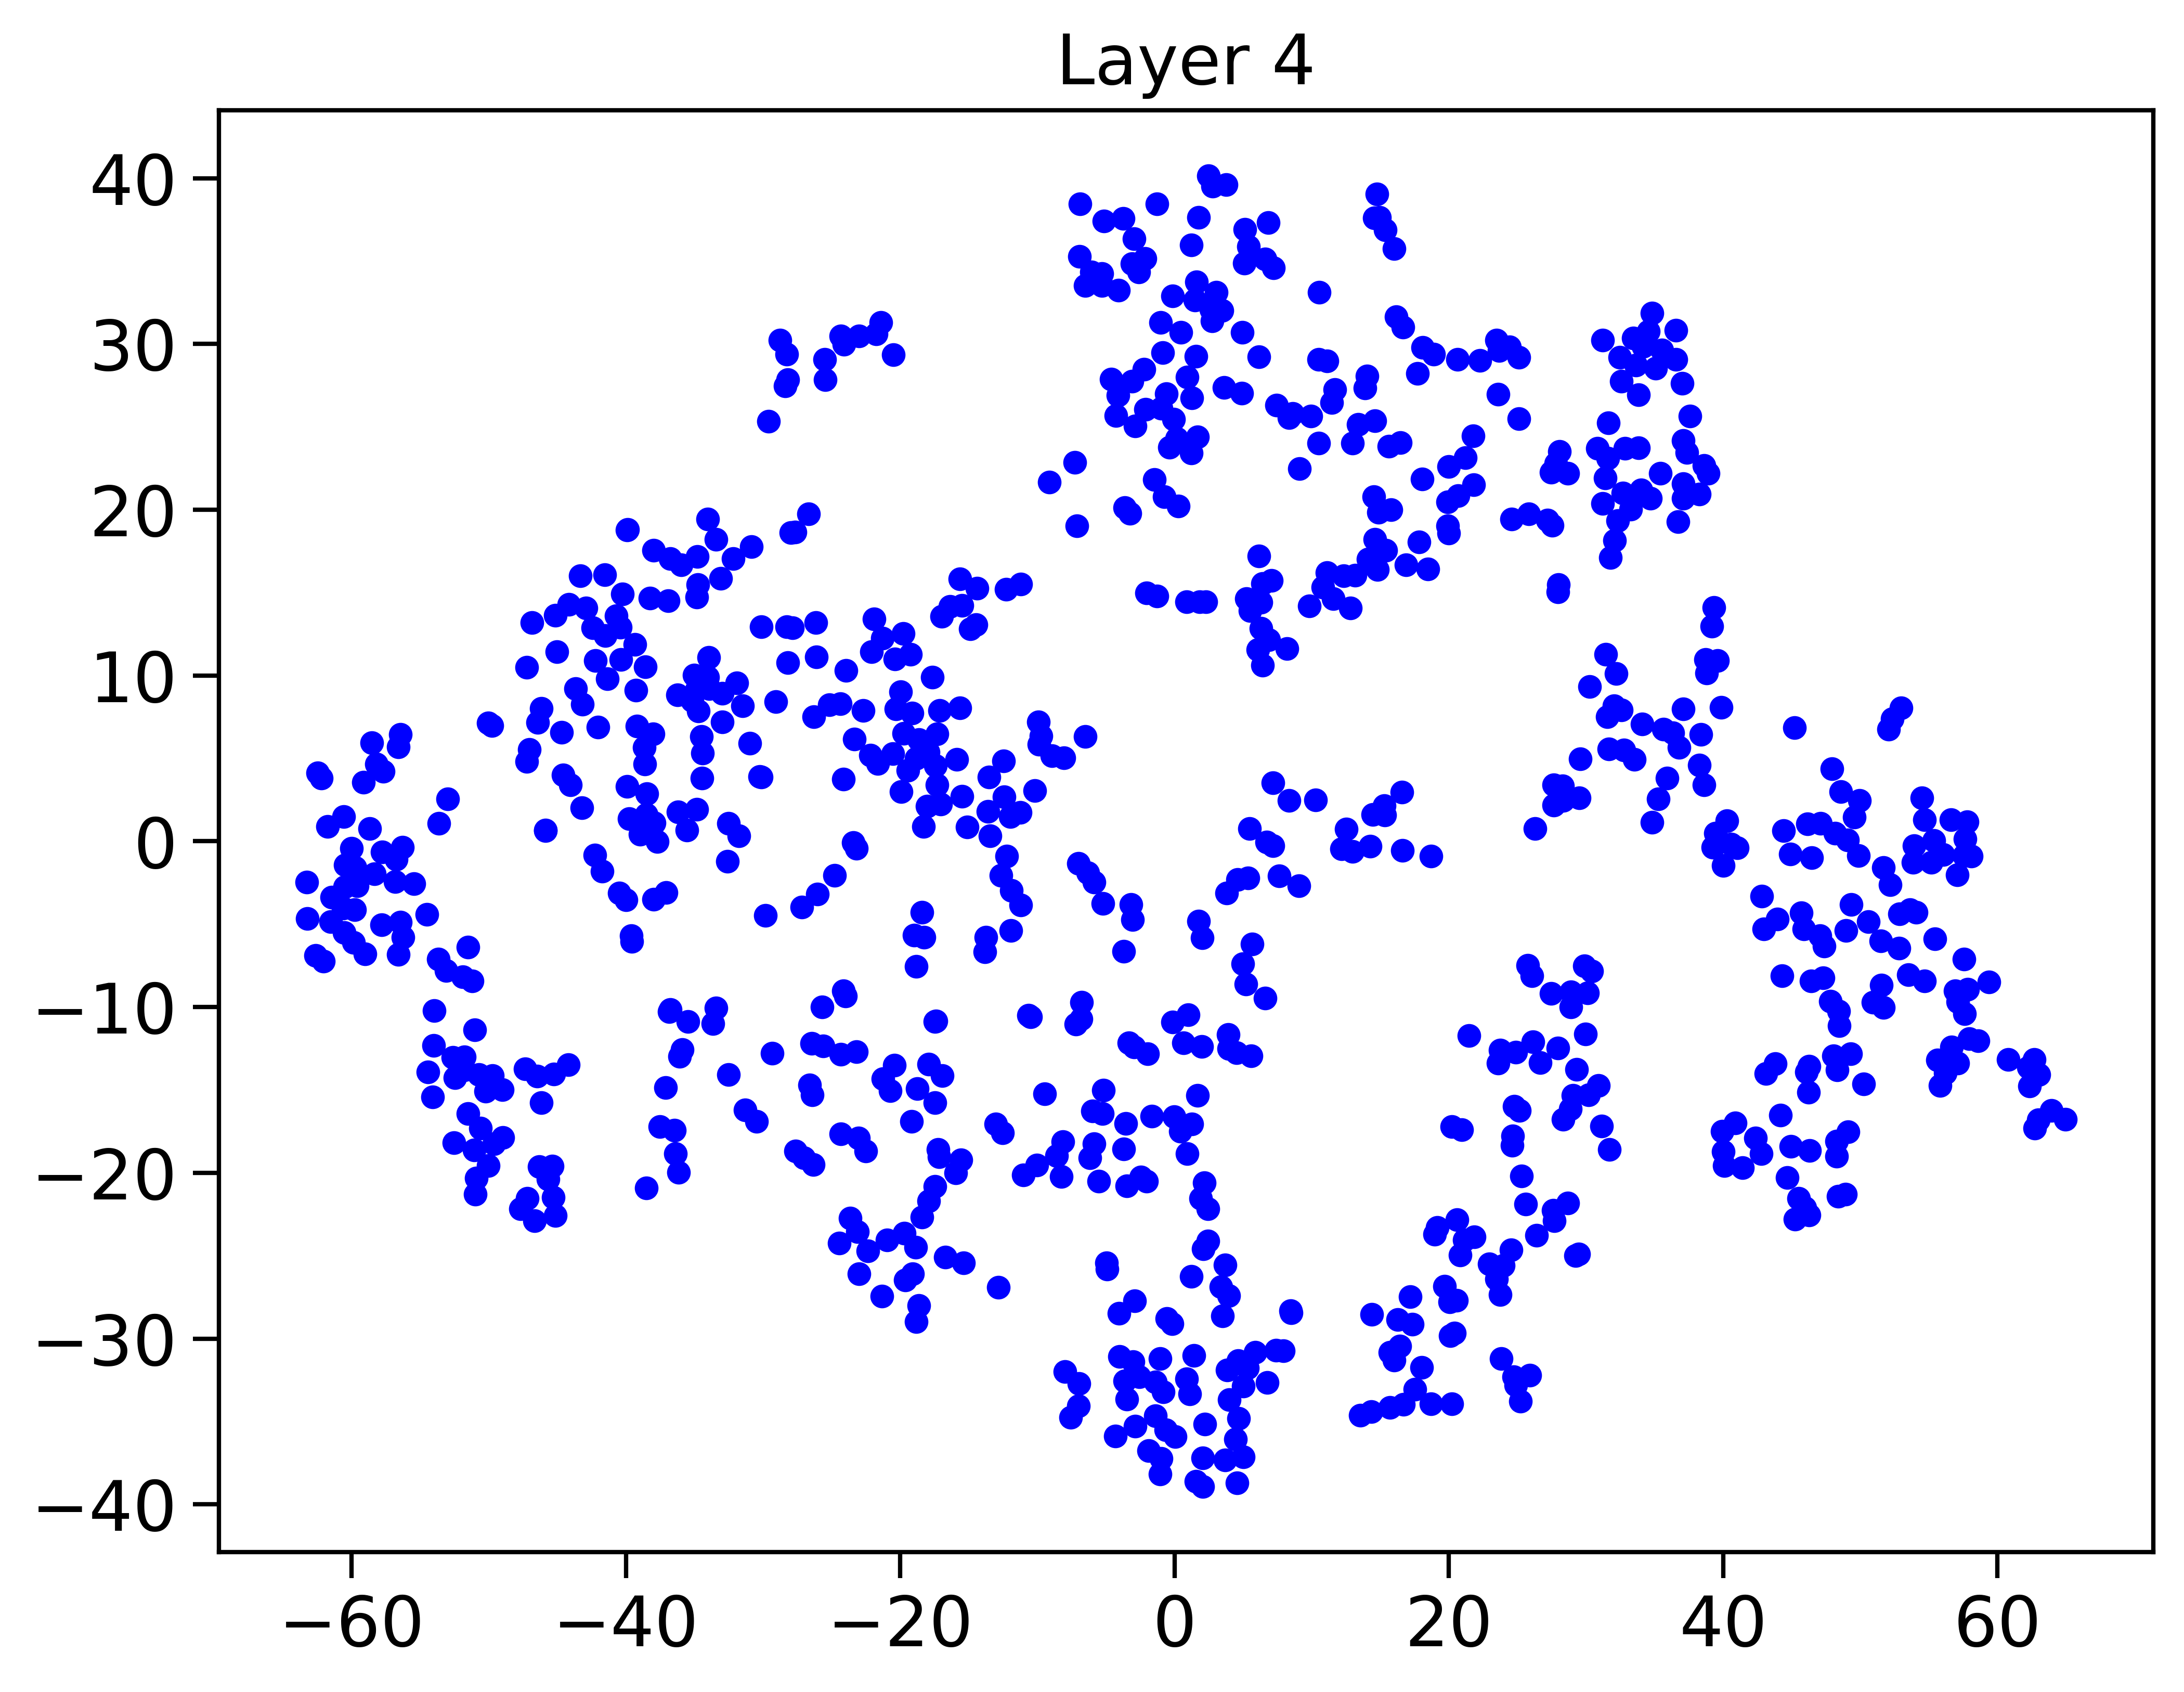

In [400]:
import scienceplots
plt.style.use(['ieee', 'notebook'])
tsne = TSNE(n_components=2, random_state=42,perplexity=perplexity)
low_dim_data = tsne.fit_transform(inps[3])
plt.scatter(low_dim_data[:, 0], low_dim_data[:, 1], s=20, color='b')
plt.title("Layer 4")


In [253]:
(low_dim_data - low_dim_data.mean())/low_dim_data.std()

array([[ 0.70167994, -1.142991  ],
       [ 1.6703084 ,  0.01433882],
       [ 0.93990403,  0.2590897 ],
       ...,
       [ 1.6120563 , -0.5937417 ],
       [-2.306039  , -0.29202747],
       [ 1.0662925 , -0.59045094]], dtype=float32)

In [262]:
(low_dim_data @ low_dim_data.T).shape

(883, 883)

In [277]:
# 计算距离矩阵
def compute_distance_matrix(data):
    # data 的形状为 N x D
    squared_diff = np.sum((data[:, np.newaxis, :] - data[np.newaxis, :, :])**2, axis=-1)
    distance_matrix = np.sqrt(squared_diff)
    return distance_matrix

def normalize_distance_matrix(distance_matrix):
    min_val = np.min(distance_matrix)
    max_val = np.max(distance_matrix)
    # 避免除零错误
    # normalized_matrix = (distance_matrix - min_val) / (max_val - min_val) if max_val > min_val else distance_matrix
    normalized_matrix = (distance_matrix) / (max_val)
    return normalized_matrix

distance_matrix = normalize_distance_matrix(compute_distance_matrix(low_dim_data))


In [303]:
import pandas as pd
real_distance = pd.read_csv('/notebooks/4901_revisit_cdtran/data/PEMS07/PEMS07.csv')

# 找到节点的范围
max_node = max(df['from'].max(), df['to'].max())
min_node = min(df['from'].min(), df['to'].min())

# 初始化邻接矩阵
num_nodes = max_node - min_node + 1
adj_matrix = np.zeros((num_nodes, num_nodes))

# 填充邻接矩阵
for _, row in df.iterrows():
    from_node = int(row['from'] - min_node)  # 调整索引从0开始
    to_node = int(row['to'] - min_node)
    adj_matrix[from_node, to_node] = row['cost']
    adj_matrix[to_node, from_node] = row['cost']



In [304]:
adj_matrix

array([[0.   , 0.   , 0.817, ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.817, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]])

In [299]:
distance_matrix

array([[0.        , 0.31298772, 0.29494184, ..., 0.22050124, 0.64824945,
        0.13729063],
       [0.31298772, 0.        , 0.15975516, ..., 0.12668589, 0.8270905 ,
        0.17726584],
       [0.29494184, 0.15975516, 0.        , ..., 0.22519599, 0.6828034 ,
        0.17812358],
       ...,
       [0.22050124, 0.12668589, 0.22519599, ..., 0.        , 0.8149713 ,
        0.11318687],
       [0.64824945, 0.8270905 , 0.6828034 , ..., 0.8149713 , 0.        ,
        0.7021139 ],
       [0.13729063, 0.17726584, 0.17812358, ..., 0.11318687, 0.7021139 ,
        0.        ]], dtype=float32)

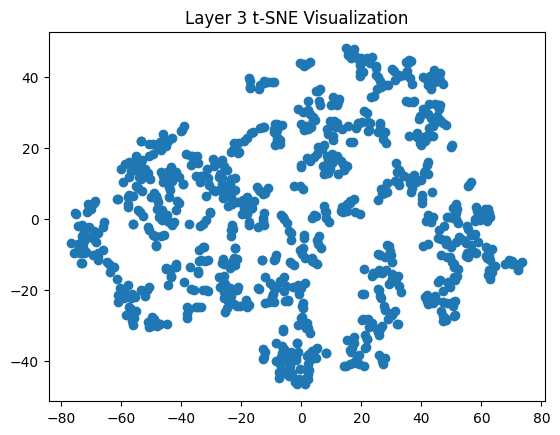

In [247]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
tsne = TSNE(n_components=2, random_state=42,perplexity=10)


low_dim_data = tsne.fit_transform(inps[3])
plt.scatter(low_dim_data[:, 0], low_dim_data[:, 1])
plt.title('Layer 3 t-SNE Visualization')
# plt.ylabel('Layer 3')
# plt.ylabel('Dimension 2')
plt.show()

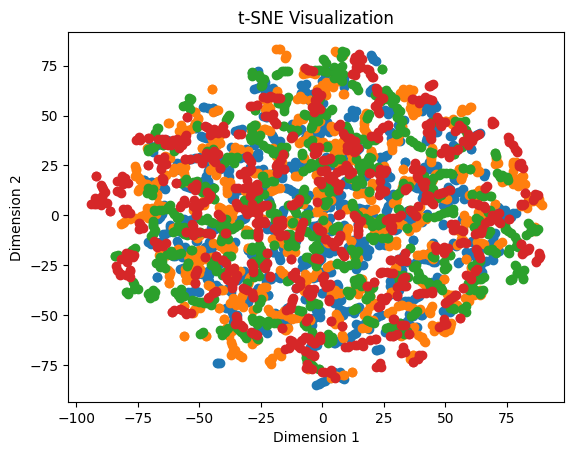

### Value

train steps: 19649
val steps: 5633
test steps: 2813
tensor([128, 320, 512], dtype=torch.int32)
self.t_index [95, 143]
resuming from /notebooks/4901_revisit_cdtran/results/runs/CiDPG/PEMS07/w96h1s12/8a8baaa19a917ec97615e6bc090c66aa/run_checkpoint.pth


/notebooks/pytorchtimseries/torch_timeseries/experiments/forecast.py:378: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(run_checkpoint_filepath, map

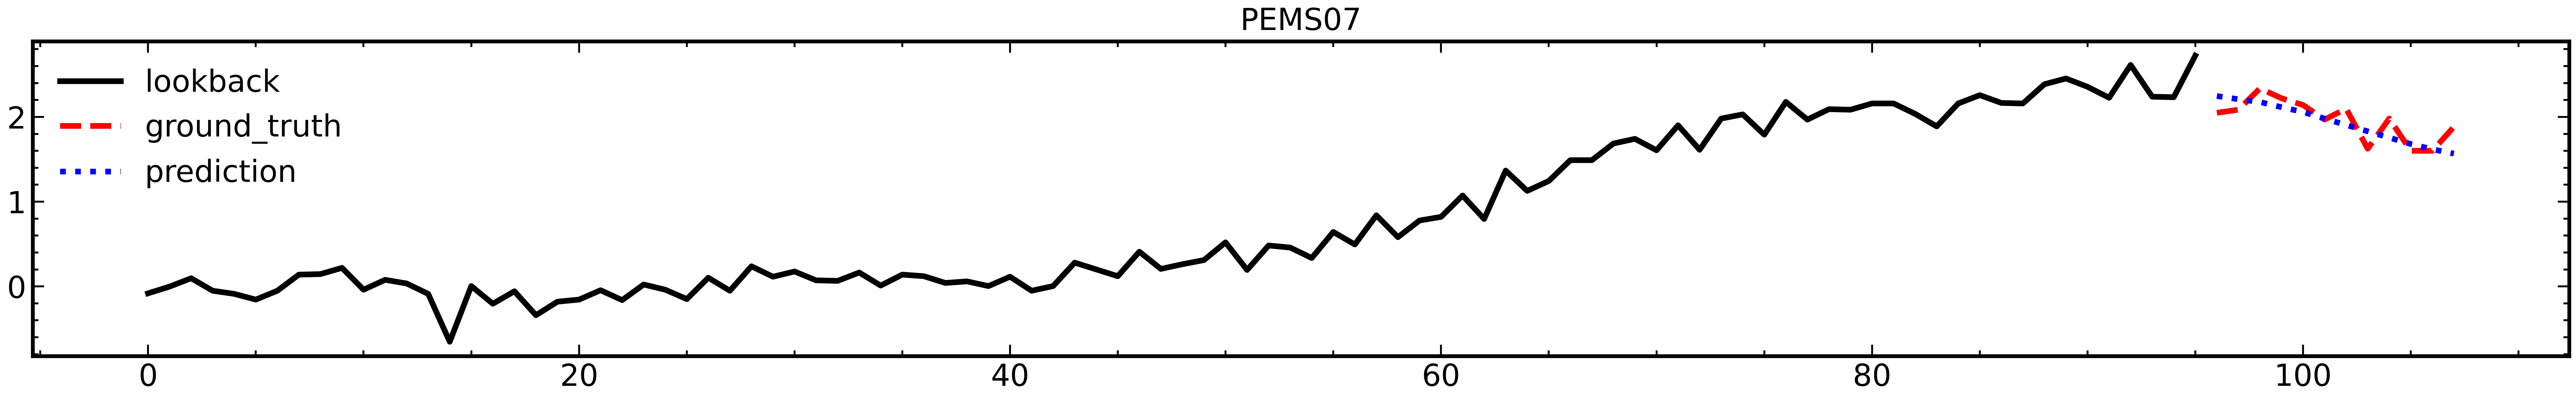

In [443]:
dataset = "PEMS07"
from src.experiments.shortterm import CiDPGForecast

exp = CiDPGForecast(dataset_type=dataset, windows=96, pred_len=12, data_path='/notebooks/4901_revisit_cdtran/data', save_dir='/notebooks/4901_revisit_cdtran/results', device='cuda:0')
exp._setup_run(1)
exp._resume_run(1)
i = 1020
b = 0
v = 580 #b500
batch_x, batch_y, origin_x, origin_y, batch_x_date_enc, batch_y_date_enc = map(lambda x: torch.tensor(x).to(exp.device).unsqueeze(0).float(),  exp.dataloader.test_loader.dataset[i])


plot_x = batch_x[b, :, v].cpu().detach().numpy()
plot_y = batch_y[b, :, v].cpu().detach().numpy()

pred_y, true_y  = exp._process_one_batch(batch_x, batch_y, batch_x_date_enc, batch_y_date_enc)

plot_pred_y = pred_y[b, :, v].cpu().detach().numpy()

# xy_plot(plot_x, plot_y, plot_pred_y, 'PEMS07', 'PAN')
x = plot_x
y = plot_y
pred_y = plot_pred_y
# plt.figure(figsize=(3, 6))
with plt.style.context(['ieee', 'notebook']):

    fig, ax = plt.subplots(figsize=(24, 3))
    
    x_ticks = np.arange(len(x))
    y_ticks = np.arange(len(x), len(x)+len(y))
    
    # 设置边框粗度
    for spine in ax.spines.values():
        spine.set_linewidth(2)  # 设置边框粗度为2

    
    ax.plot(x_ticks, x, label='lookback', linewidth=3)
    ax.plot(y_ticks, y, label='ground_truth', linewidth=3)
    ax.plot(y_ticks, pred_y, label='prediction', linewidth=3)
# if y_label: plt.ylabel('PEMS07')
plt.title('PEMS07')
plt.legend()
plt.show()


In [415]:
for i in range(0, 4):
    # print(compute_cka(exp.model.prevs[0][0].detach().cpu().numpy(), exp.model.prevs[i][0].detach().cpu().numpy()))
    print(compute_cka(exp.model.prevs[0][0].detach().cpu().numpy(), exp.model.prevs[i][0].detach().cpu().numpy()), 
          compute_cka(standardize(batch_y[0].transpose(0,1).detach().cpu().numpy()) , exp.model.prevs[i][0].detach().cpu().numpy()))
    
    # exp.model.init_embedding[0]
    
    

1.0 0.08568580358090992
0.7200538591254788 0.10873463852040079
0.2873470142431093 0.2568581007632977
0.17574323965328137 0.2789665560843655


In [419]:
gt = [0.08568580358090992, 0.10873463852040079, 0.25685810076329, 0.2789665560843655]
f1 = [ 1.0 ,0.7200538591254788 , 0.2873470142431093 ,0.17574323965328137]





Text(0.5, 1.0, 'CKA similarity With First Layer')

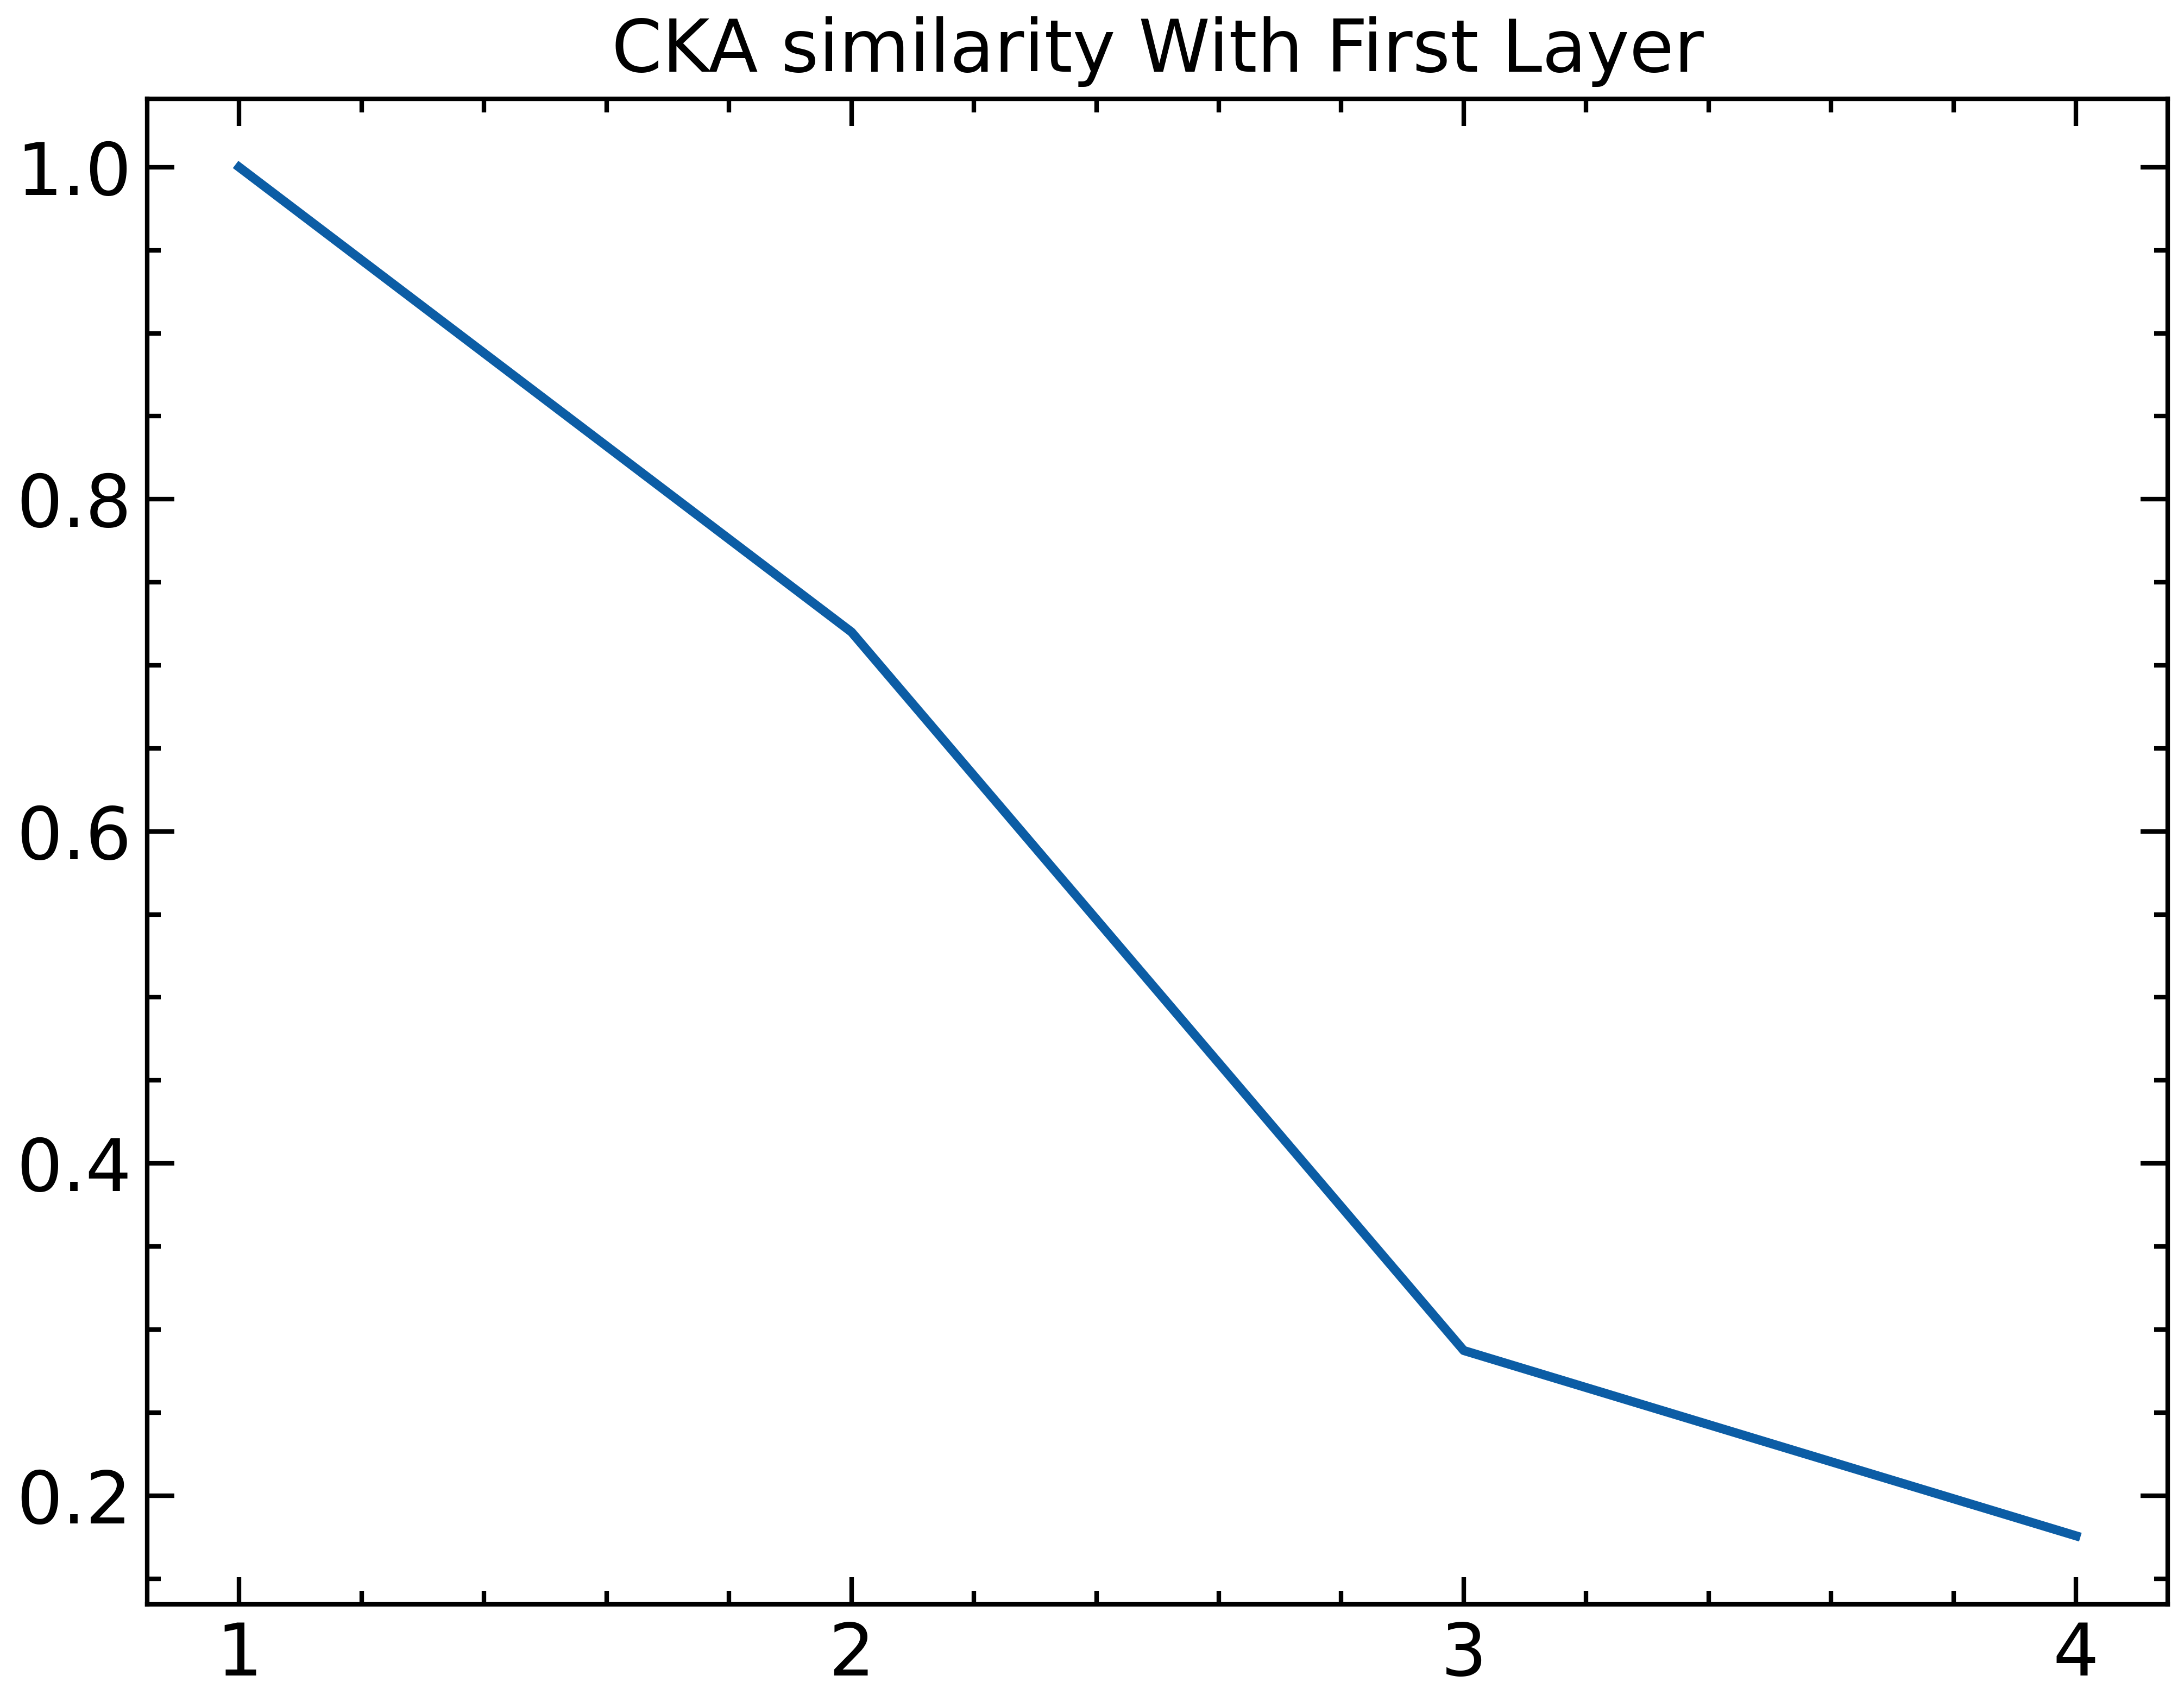

In [427]:
plt.style.use(['science', 'notebook'])
# plt.plot([1,2,3,4], gt)
plt.plot([1,2,3,4], f1)
plt.xticks([1,2,3,4])
plt.title('CKA similarity With First Layer')

### patches

In [461]:
batch_x[0].transpose(0,1).detach().cpu().numpy().shape

(883, 96)

### channel-tse

In [471]:
inpe = batch_x[0].detach().cpu().numpy()

tsne = TSNE(n_components=2, random_state=42,perplexity=20)
low_dim_data = tsne.fit_transform(inpe)
# plt.scatter(low_dim_data[:, 0], low_dim_data[:, 1], s=20, color='b')


/tmp/ipykernel_773808/948535475.py:17: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cm.ScalarMappable(norm=norm, cmap="Blues"), label="Metrics")  # 添加颜色条


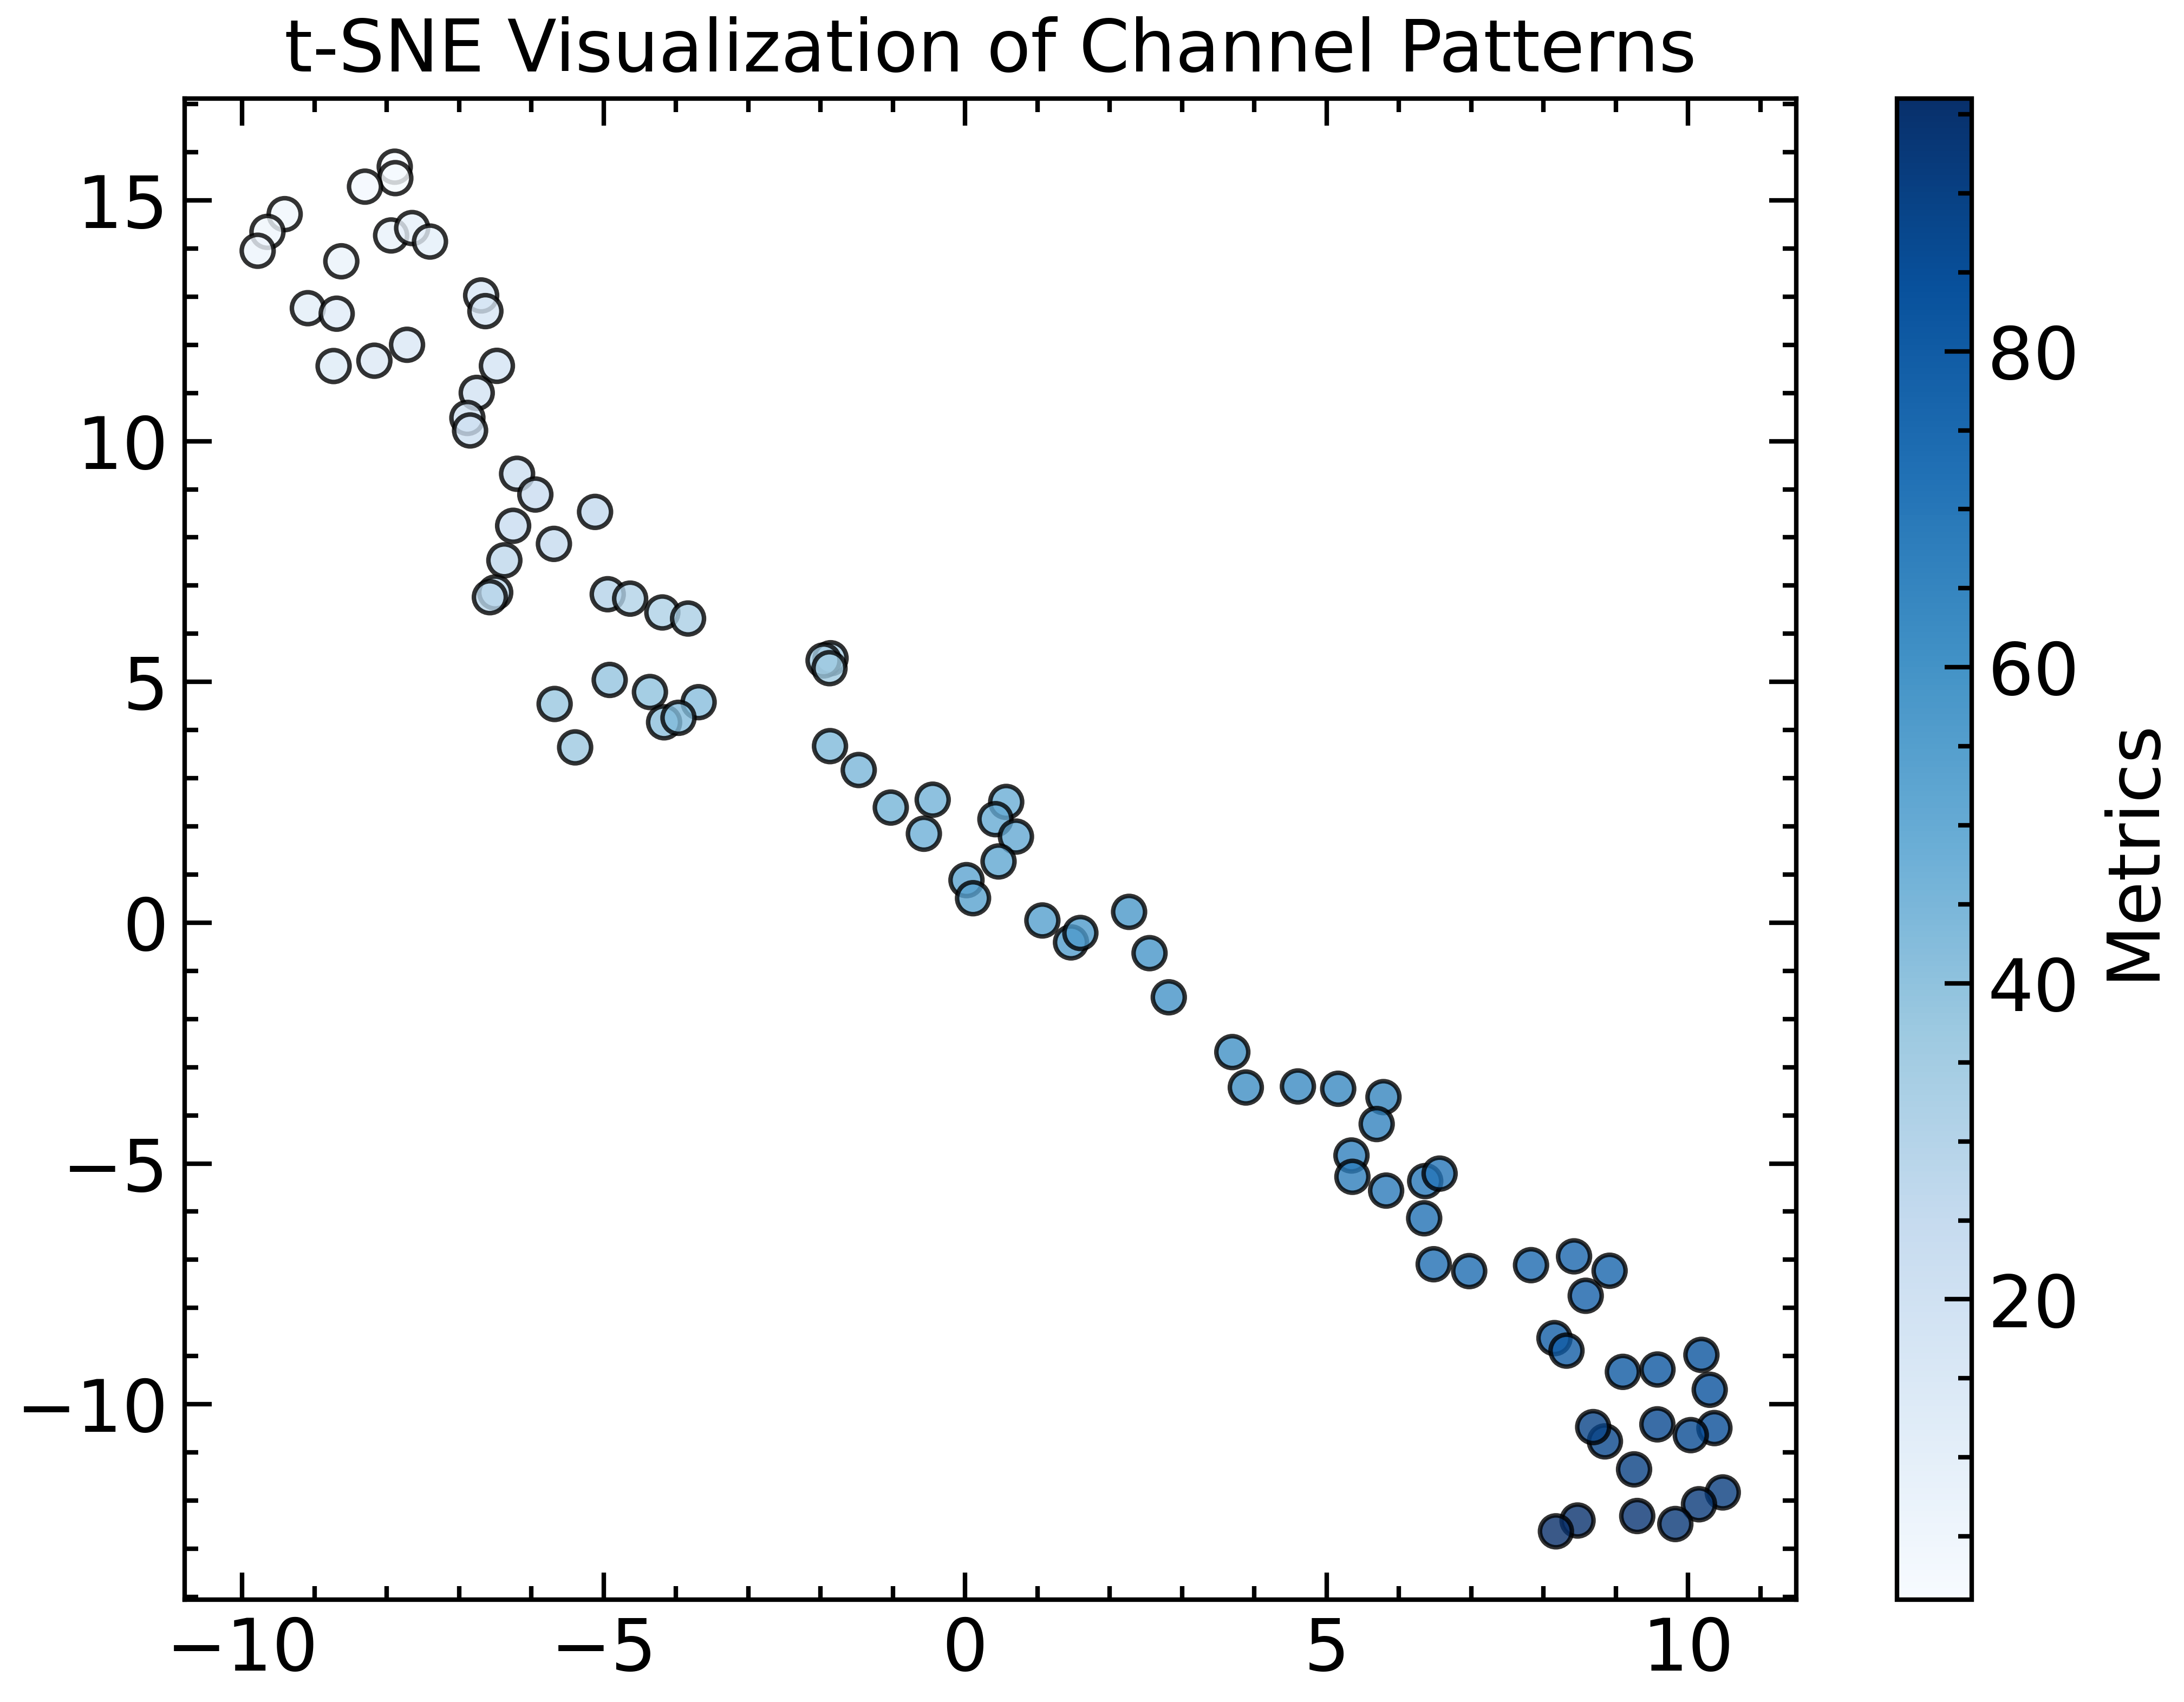

In [474]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib import cm

# 示例数据
np.random.seed(42)
metrics = np.array(list(range(1, 97)))#np.random.randint(10, 100, size=50)  # 示例标准，随机生成50个值

# 归一化标准值到[0, 1]范围
norm = Normalize(vmin=metrics.min(), vmax=metrics.max())
colors = cm.Blues(norm(metrics))  # 映射到蓝色渐变

# 绘制散点图
plt.figure(figsize=(8, 6))
plt.scatter(low_dim_data[:, 0], low_dim_data[:, 1], s=50, color=colors, edgecolors="k", alpha=0.8)
plt.colorbar(cm.ScalarMappable(norm=norm, cmap="Blues"), label="Metrics")  # 添加颜色条
plt.title("t-SNE Visualization of Channel Patterns")
# plt.xlabel("X-axis")
# plt.ylabel("Y-axis")
# plt.grid()
plt.show()


In [479]:
inpe

array([[0.6127419 , 0.9131608 , 0.3696153 , ..., 0.68517184, 0.50592005,
        0.5572172 ],
       [0.39496163, 0.4508466 , 0.7950079 , ..., 0.5305197 , 0.7045401 ,
        0.6776572 ],
       [0.43851766, 1.3951479 , 0.37409312, ..., 0.7037301 , 0.6694895 ,
        0.78605324],
       ...,
       [0.48829603, 0.37215483, 0.86217517, ..., 0.5738223 , 1.6275389 ,
        0.56926113],
       [0.9798572 , 0.32297248, 0.5576836 , ..., 0.6294971 , 1.1952484 ,
        0.6957232 ],
       [0.6936317 , 0.40166426, 1.0323322 , ..., 0.47484496, 1.8378425 ,
        0.8522953 ]], dtype=float32)

### patches-tsn

In [76]:
inpe = batch_x[0]
patch_inpe = torch.nn.functional.pad(inpe.transpose(0,1), pad=(24, 0))
# patch_inpe = inpe.unfold(dimension=-1, size=48, step=2)
patch_inpe = patch_inpe.unfold(dimension=-1, size=48, step=24)
# patch_inpe = patch_inpe.reshape(-1, 48)


In [69]:
# patch_inpe.transpose(0,1).shape

In [78]:
patch_inpe.shape

torch.Size([883, 4, 48])

In [71]:
# tsne = TSNE(n_components=2, random_state=42,perplexity=10)
# low_dim_data = tsne.fit_transform(patch_inpe[:, 0, :].detach().cpu().numpy())
# plt.scatter(low_dim_data[:, 0], low_dim_data[:, 1], s=50, edgecolors="k", alpha=0.8)


In [79]:
selected_stations = [1,2,3,4,5,6,7,8,9,10, 11, 23, 34]
patch_inpe = patch_inpe[[1,2,3,4,5,6,7,8,9,10, 11, 23, 34], :, :]

In [80]:
patch_inpe = patch_inpe.transpose(0,1).reshape(-1, 48).detach().cpu().numpy()

In [81]:
patch_inpe.shape

(52, 48)

/tmp/ipykernel_1200601/302007465.py:25: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cm.ScalarMappable(norm=norm, cmap="Blues"), label="Metrics")  # 添加颜色条


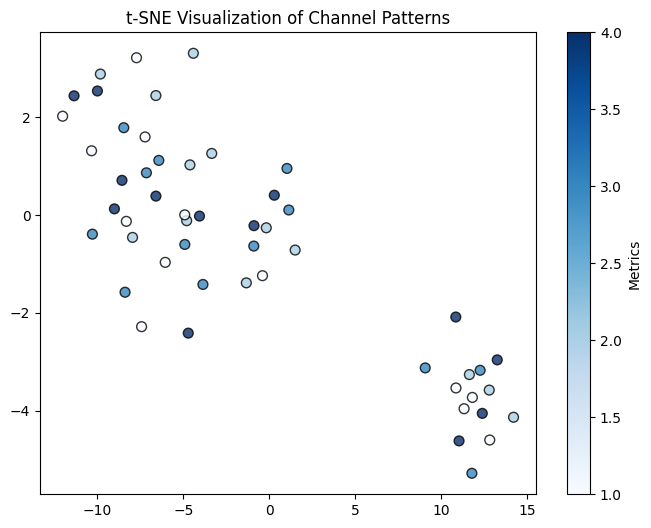

In [82]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib import cm


# inpe = batch_x[0].detach().cpu().numpy().transpose()

tsne = TSNE(n_components=2, random_state=40,perplexity=10)
low_dim_data = tsne.fit_transform(patch_inpe)
# plt.scatter(low_dim_data[:, 0], low_dim_data[:, 1], s=20, color='b')


# 示例数据
np.random.seed(42)
metrics = np.array(list(range(1, 5))*len(selected_stations)) #np.random.randint(10, 100, size=50)  # 示例标准，随机生成50个值
# metrics = metrics[0:3000]
# 归一化标准值到[0, 1]范围
norm = Normalize(vmin=metrics.min(), vmax=metrics.max())
colors = cm.Blues(norm(metrics))  # 映射到蓝色渐变

# 绘制散点图
plt.figure(figsize=(8, 6))
plt.scatter(low_dim_data[:, 0], low_dim_data[:, 1], s=50, color=colors, edgecolors="k", alpha=0.8)
plt.colorbar(cm.ScalarMappable(norm=norm, cmap="Blues"), label="Metrics")  # 添加颜色条
plt.title("t-SNE Visualization of Channel Patterns")
# plt.xlabel("X-axis")
# plt.ylabel("Y-axis")
# plt.grid()
plt.show()


## PEMS-BAY

In [364]:
from src.experiments.shortterm.PAN import PANForecast
dataset = "PEMS_BAY"
exp = PANForecast(dataset_type=dataset, d_c=128, d_patch=128, patch_len=48, stride=24, windows=96, horizon=1, pred_len=12, data_path='/notebooks/4901_revisit_cdtran/data', save_dir='/notebooks/4901_revisit_cdtran/results', device='cuda:0')
exp._setup_run(1)
exp._resume_run(1)



train steps: 36374
val steps: 10412
test steps: 5201
tensor([128, 224, 320, 416, 512], dtype=torch.int32)
4
self.t_index [47, 71, 95, 119]
not raw_info..
resuming from /notebooks/4901_revisit_cdtran/results/runs/PAN/PEMS_BAY/w96h1s12/39d6b1a41bd79861e5c32d8196333266/run_checkpoint.pth


/notebooks/pytorchtimseries/torch_timeseries/experiments/forecast.py:378: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(run_checkpoint_filepath, map

In [367]:
# i = 250
# b = 0
# v = 8 

i = 250
b = 0
v = 30 



batch_x, batch_y, origin_x, origin_y, batch_x_date_enc, batch_y_date_enc = map(lambda x: torch.tensor(x).to(exp.device).unsqueeze(0).float(),  exp.dataloader.test_loader.dataset[i])
pred_y, true_y  = exp._process_one_batch(batch_x, batch_y, batch_x_date_enc, batch_y_date_enc)


# batch_x, batch_y, origin_x, origin_y, batch_x_date_enc, batch_y_date_enc = map(lambda x: x.to(exp.device).float(), next(iter(exp.test_loader)))
plot_pred_y = pred_y[b, :, v].cpu().detach().numpy()


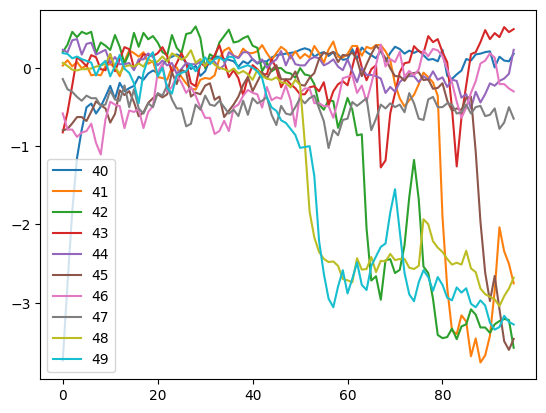

In [368]:
start = 40
for i in range(10):
    plt.plot(batch_x[b, :, start+i].cpu().detach().numpy(), label=start+i)
plt.legend()

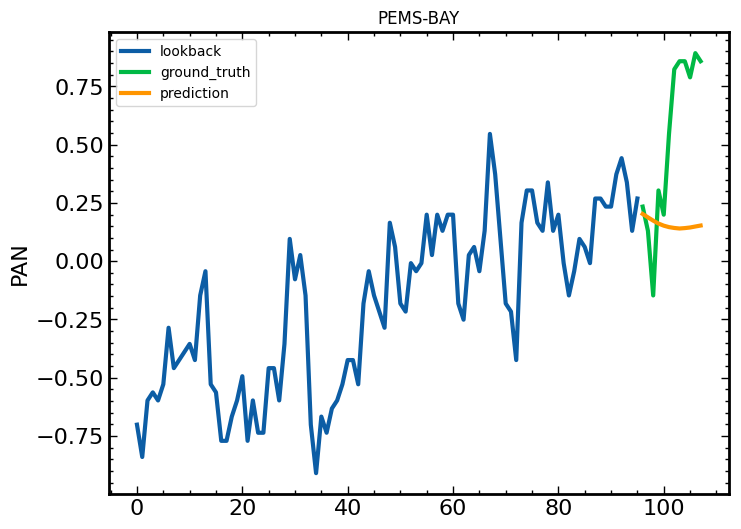

In [369]:

plot_x = batch_x[b, :, v].cpu().detach().numpy()
plot_y = batch_y[b, :, v].cpu().detach().numpy()
plot_pred_y = pred_y[b, :, v].cpu().detach().numpy()


x_ticks = np.arange(len(plot_x))
y_ticks = np.arange(len(plot_x), len(plot_x)+len(plot_y))

xy_plot(plot_x, plot_y, plot_pred_y, 'PEMS-BAY', 'PAN')

plt.show()


### TSNE

In [370]:
inp = exp.model.prevs[0][0].detach().cpu().numpy()
target_length = exp.model.prevs[-1][0].shape[1]
# inps = [ np.pad(p[0].detach().cpu().numpy(), (target_length - p[0].detach().cpu().numpy().shape[1], 0), mode='constant') for p in  exp.model.prevs ]
# inps = np.array([torch.nn.functional.pad(p[0], (0, target_length - p[0].shape[1])).cpu().detach().numpy() for p in  exp.model.prevs ])
inps = [p[0].cpu().detach().numpy() for p in  exp.model.prevs ]
# np.pad(data, (0, target_length - len(data)), mode='constant', constant_values=padding_value)


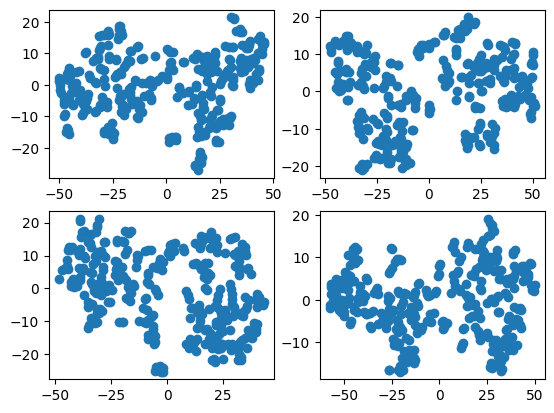

In [384]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
i = 12000

batch_x, batch_y, origin_x, origin_y, batch_x_date_enc, batch_y_date_enc = map(lambda x: torch.tensor(x).to(exp.device).unsqueeze(0).float(),  exp.dataloader.test_loader.dataset[i])
pred_y, true_y  = exp._process_one_batch(batch_x, batch_y, batch_x_date_enc, batch_y_date_enc)

fig, axs = plt.subplots(2, 2)
perplexity = 15 # 13
for i in range(0, 2):
    tsne = TSNE(n_components=2, random_state=42,perplexity=perplexity)
    low_dim_data = tsne.fit_transform(inps[i])
    # tsne_distance_matrix = normalize_distance_matrix(compute_distance_matrix(low_dim_data))
    # print(np.abs((real_distance_matrix - tsne_distance_matrix)).sum())
    axs[0, i].scatter(low_dim_data[:, 0], low_dim_data[:, 1])

for i in range(0, 2):
    tsne = TSNE(n_components=2, random_state=42,perplexity=perplexity)
    low_dim_data = tsne.fit_transform(inps[i+2])
    # tsne_distance_matrix = normalize_distance_matrix(compute_distance_matrix(low_dim_data))
    # print(np.abs((real_distance_matrix - tsne_distance_matrix)).sum())

    axs[1, i].scatter(low_dim_data[:, 0], low_dim_data[:, 1])



# plt.scatter(low_dim_data[:, 0], low_dim_data[:, 1])
# plt.title('t-SNE Visualization')
# plt.xlabel('Dimension 1')
# plt.ylabel('Dimension 2')
plt.show()

### geo

In [334]:
path = '/notebooks/4901_revisit_cdtran/data/PEMS-BAY/graph_sensor_locations_bay.csv'
import pandas as pd
# df = pd.read_csv(path, columns=['id', 'latitude', 'longtitude'])
df = pd.read_csv(path, header=None)
df.columns = ['id', 'latitude', 'longitude']


In [332]:
!pip install folium

^C


In [331]:
# 1. 创建地理地图，以数据中心为地图中心点
center_lat = df['latitude'].mean()
center_lon = df['longitude'].mean()
map_geo = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# 2. 将数据点添加到地图中
for _, row in df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"ID: {row['id']}, Cluster: {row['cluster']}",
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(map_geo)

# 保存并显示地图
map_file_path = "/mnt/data/geo_map.html"
map_geo.save(map_file_path)



,id,latitude,longtitude
0,400001,37.364085,-121.901149
1,400017,37.253303,-121.945440
2,400030,37.359087,-121.906538
3,400040,37.294949,-121.873109
4,400045,37.363402,-121.902233
...,...,...,...
320,413845,37.422887,-121.925747
321,413877,37.321613,-121.899642
322,413878,37.324641,-121.888603
323,414284,37.323066,-121.896538


### distantce

In [350]:
from scipy.spatial.distance import cdist

# 2. 获取距离矩阵（使用欧几里得距离）
coords = df[['latitude', 'longitude']].to_numpy()
distance_matrix = cdist(coords, coords, metric='euclidean')

def normalize_distance_matrix(distance_matrix):
    min_val = np.min(distance_matrix)
    max_val = np.max(distance_matrix)
    # 避免除零错误
    # normalized_matrix = (distance_matrix - min_val) / (max_val - min_val) if max_val > min_val else distance_matrix
    normalized_matrix = (distance_matrix) / (max_val)
    return normalized_matrix
real_distance_matrix = normalize_distance_matrix(distance_matrix)

1.0

In [355]:
tsne = TSNE(n_components=2, random_state=42,perplexity=perplexity)
low_dim_data = tsne.fit_transform(inps[3])

# 计算距离矩阵
def compute_distance_matrix(data):
    # data 的形状为 N x D
    squared_diff = np.sum((data[:, np.newaxis, :] - data[np.newaxis, :, :])**2, axis=-1)
    distance_matrix = np.sqrt(squared_diff)
    return distance_matrix


tsne_distance_matrix = normalize_distance_matrix(compute_distance_matrix(low_dim_data))


In [351]:
tsne_distance_matrix

array([[0.        , 0.21382071, 0.06944115, ..., 0.17243491, 0.58517766,
        0.17862837],
       [0.21382071, 0.        , 0.22737487, ..., 0.22930495, 0.6286082 ,
        0.33528176],
       [0.06944115, 0.22737487, 0.        , ..., 0.23999009, 0.51574135,
        0.24157718],
       ...,
       [0.17243491, 0.22930495, 0.23999009, ..., 0.        , 0.7521294 ,
        0.13491873],
       [0.58517766, 0.6286082 , 0.51574135, ..., 0.7521294 , 0.        ,
        0.7468134 ],
       [0.17862837, 0.33528176, 0.24157718, ..., 0.13491873, 0.7468134 ,
        0.        ]], dtype=float32)

In [359]:
np.abs((real_distance_matrix - tsne_distance_matrix)).sum()

26125.68663283081

## ExchangeRate

In [430]:
from src.experiments.CiDPG import CiDPGForecast

exp = CiDPGForecast(dataset_type='ExchangeRate', windows=336, horizon=1, pred_len=720, data_path='/notebooks/pytorchtimseries/data', save_dir='/notebooks/4901_revisit_cdtran/results', device='cuda:0')
exp._setup_run(1)
exp._resume_run(1)

i = 0
b = 0
v = 5


# i = 1000
batch_x, batch_y, origin_x, origin_y, batch_x_date_enc, batch_y_date_enc = map(lambda x: torch.tensor(x).to(exp.device).unsqueeze(0).float(),  exp.dataloader.test_loader.dataset[i])


plot_x = batch_x[b, :, v].cpu().detach().numpy()
plot_y = batch_y[b, :, v].cpu().detach().numpy()

x_ticks = np.arange(len(plot_x))
y_ticks = np.arange(len(plot_x), len(plot_x)+len(plot_y))

# batch_x, batch_y, origin_x, origin_y, batch_x_date_enc, batch_y_date_enc = map(lambda x: x.to(exp.device).float(), next(iter(exp.test_loader)))
pred_y, true_y  = exp._process_one_batch(batch_x, batch_y, batch_x_date_enc, batch_y_date_enc)
plot_pred_y = pred_y[b, :, v].cpu().detach().numpy()


Using downloaded and verified file: /notebooks/pytorchtimseries/data/ExchangeRate/exchange_rate.csv
train steps: 4256
val steps: 798
test steps: 41
tensor([128, 182, 238, 292, 348, 402, 458, 512], dtype=torch.int32)
self.t_index [95, 143, 191, 239, 287, 335, 383]
resuming from /notebooks/4901_revisit_cdtran/results/runs/CiDPG/ExchangeRate/w336h1s720/b5d8417215bf20d2f9e7ac6b5f0691fd/run_checkpoint.pth


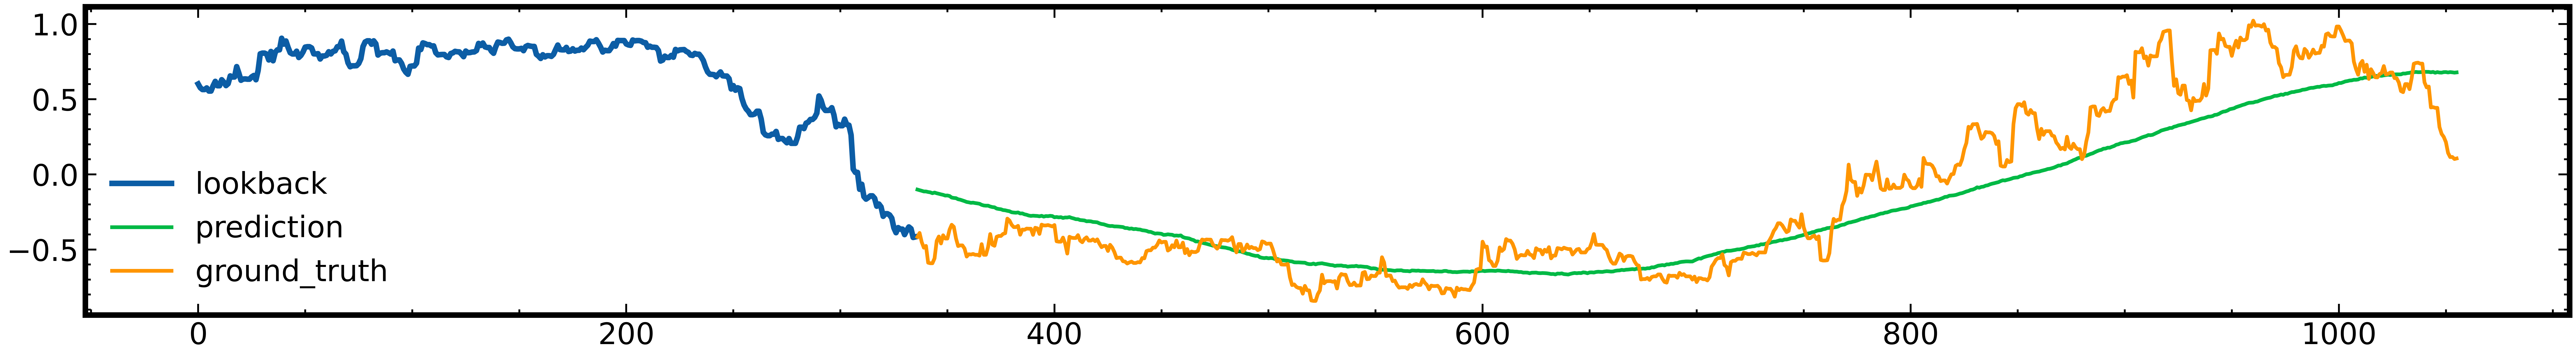

In [432]:

plt.figure(figsize=(24,3))
plt.plot(x_ticks, plot_x, label='lookback', linewidth=3)
# 设置图表边框的粗细
for spine in plt.gca().spines.values():
    spine.set_linewidth(3)

plt.plot(y_ticks, plot_pred_y, label='prediction')
plt.plot(y_ticks, plot_y, label='ground_truth')
plt.legend()
# plot_pred_y = pred_y[b, :, :].cpu().detach().numpy()
# plt.plot(x_ticks, batch_x[0].cpu().detach().numpy(), label='lookback')
# plt.plot(y_ticks, batch_y[0].cpu().detach().numpy(), label='ground_truth')
# plt.plot(y_ticks, plot_pred_y, label='prediction')
# pred_y, true_y  = exp._process_one_batch(batch_x, batch_y, batch_x_date_enc, batch_y_date_enc)
# plot_pred_y = pred_y[b, :, v].cpu().detach().numpy()
# xy_plot(plot_x, plot_y, plot_pred_y, 'PEMS07', 'PAN')
# plt.savefig('./a.svg')

# plt.show()
# plt.savefig('./a.svg')


In [433]:
inp = exp.model.prevs[0][0].detach().cpu().numpy()
target_length = exp.model.prevs[-1][0].shape[1]
# inps = [ np.pad(p[0].detach().cpu().numpy(), (target_length - p[0].detach().cpu().numpy().shape[1], 0), mode='constant') for p in  exp.model.prevs ]
# inps = np.array([torch.nn.functional.pad(p[0], (0, target_length - p[0].shape[1])).cpu().detach().numpy() for p in  exp.model.prevs ])
inps = [p[0].cpu().detach().numpy() for p in  exp.model.prevs ]
# np.pad(data, (0, target_length - len(data)), mode='constant', constant_values=padding_value)


In [437]:
inps[0].shape

(8, 182)

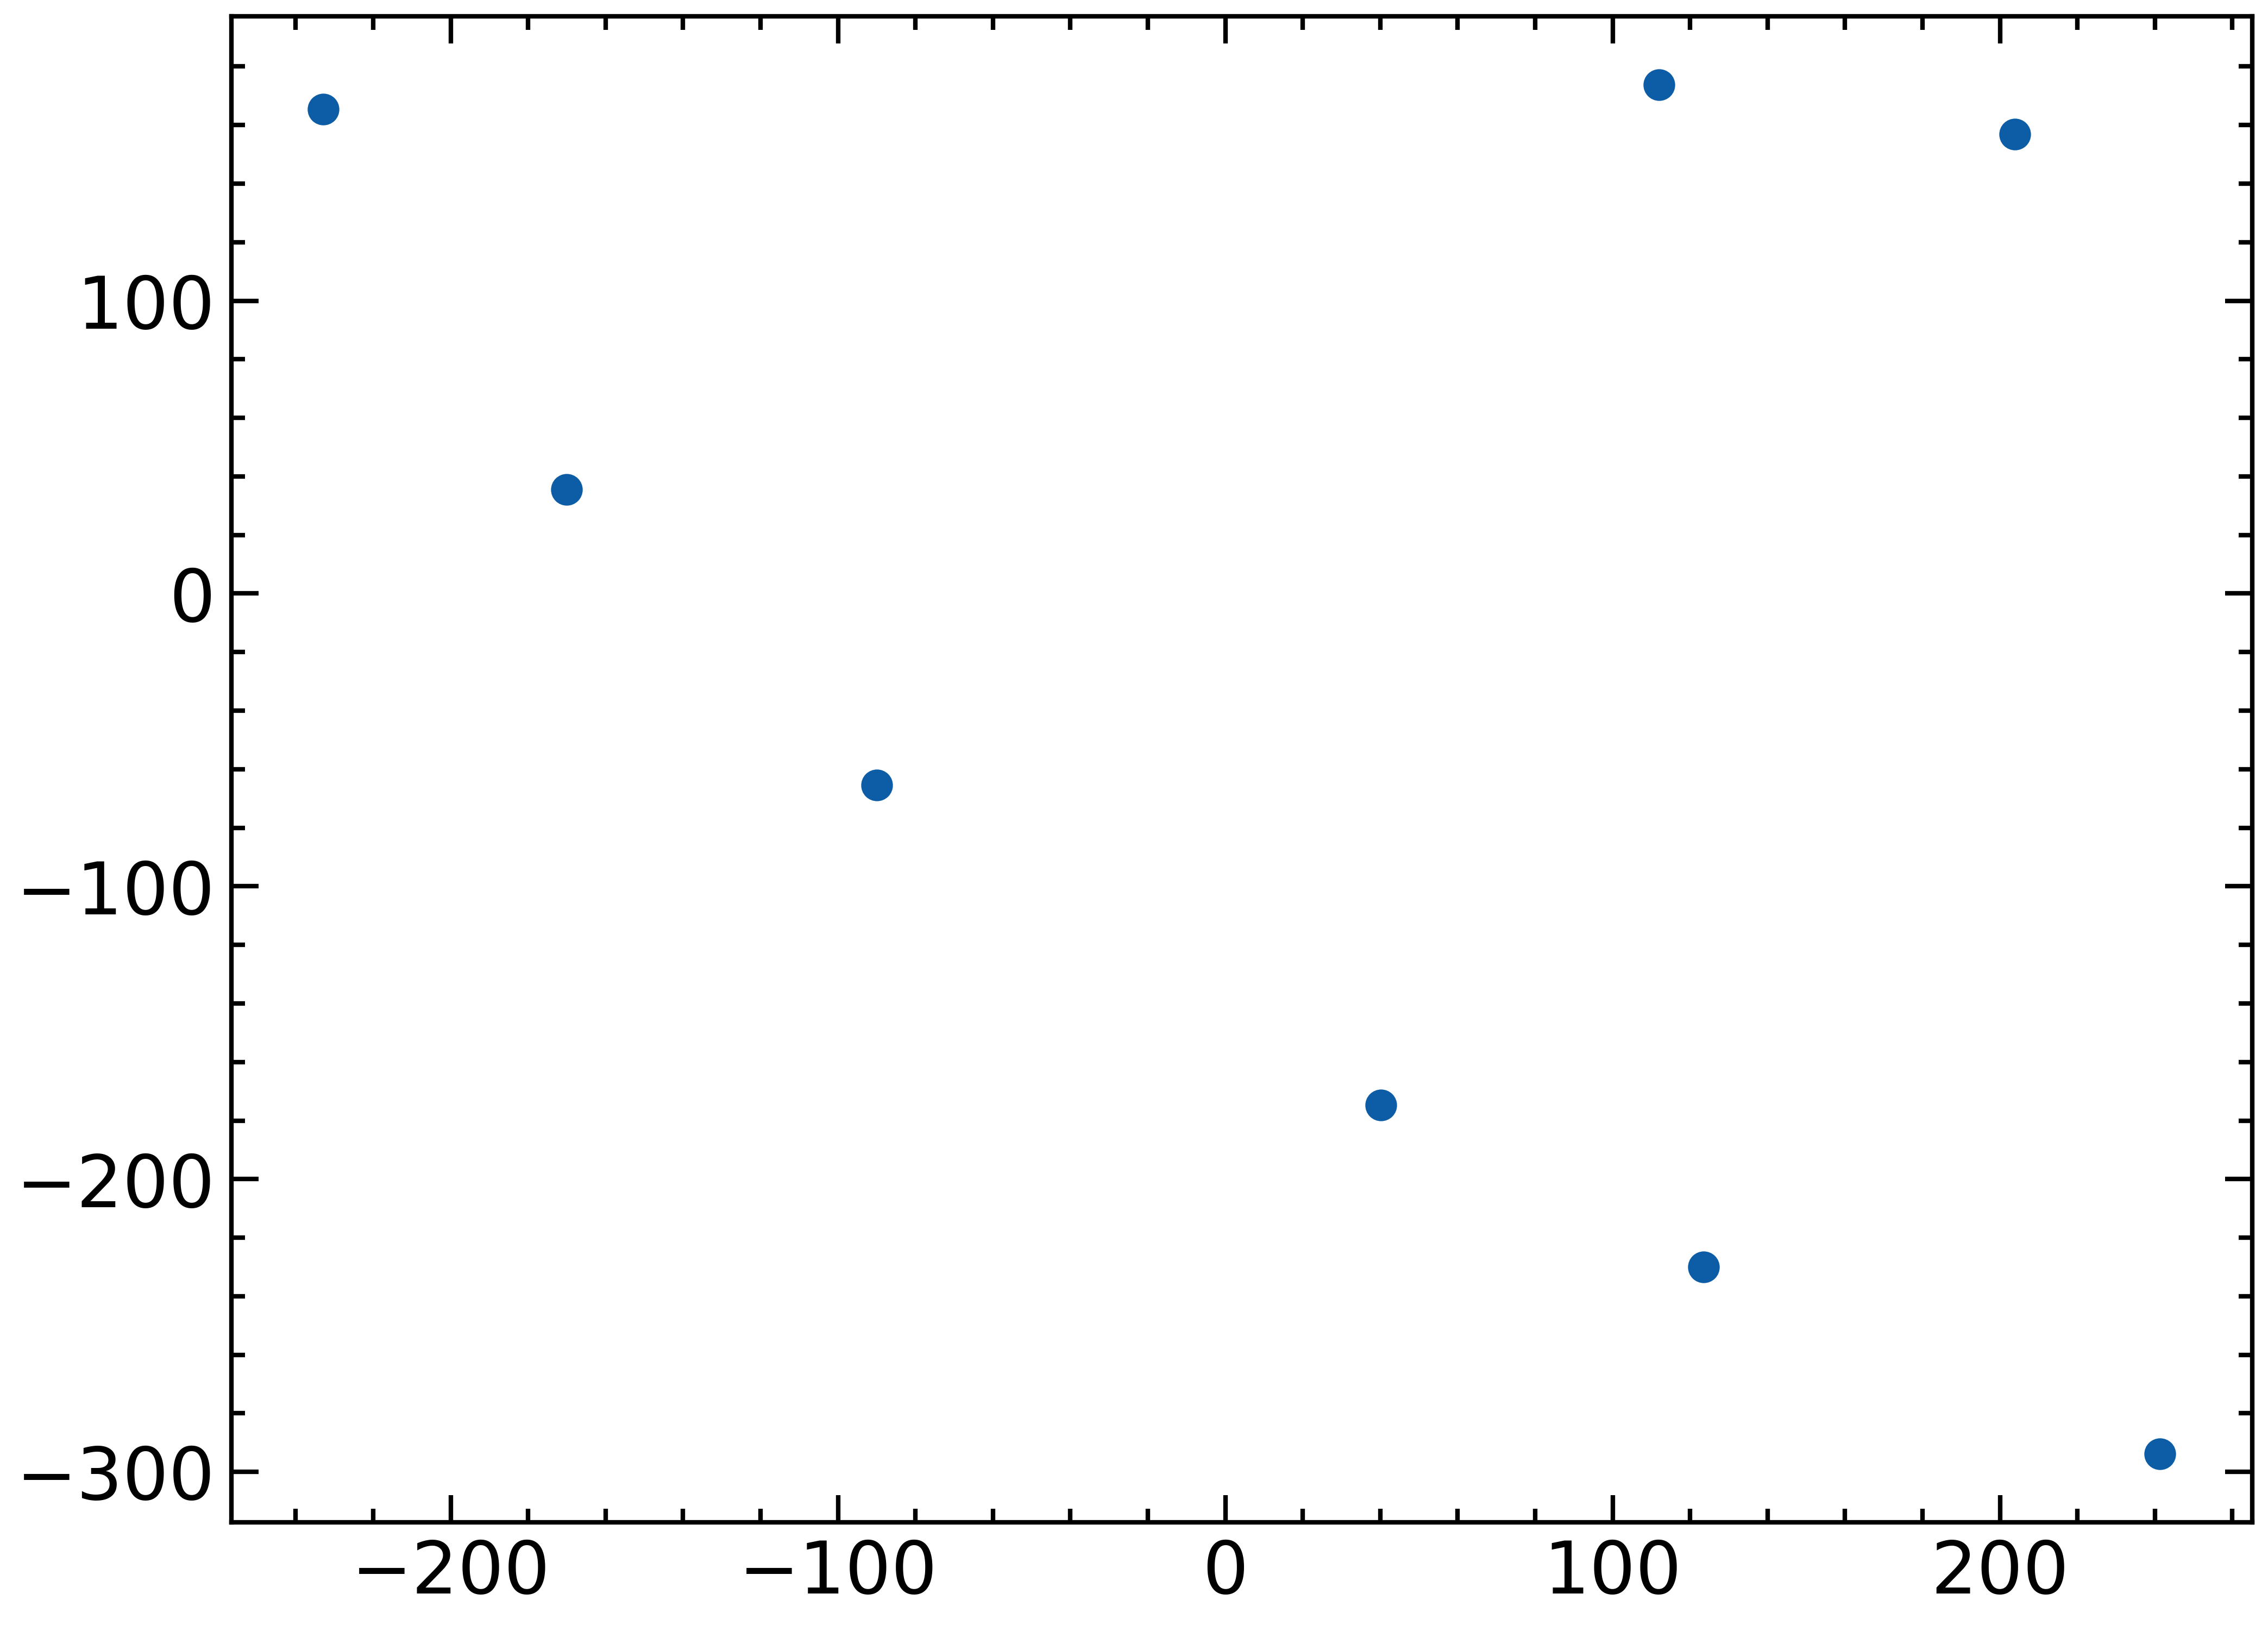

In [435]:
tsne = TSNE(n_components=2, random_state=42,perplexity=2)
low_dim_data = tsne.fit_transform(inps[0])

plt.scatter(low_dim_data[:, 0], low_dim_data[:, 1])


In [450]:
df

,7.109999999999999432e+01,6.600000000000000000e+01,6.459999999999999432e+01,6.559999999999999432e+01,6.709999999999999432e+01,7.190000000000000568e+01,6.859999999999999432e+01,6.770000000000000284e+01,6.579999999999999716e+01,4.089999999999999858e+01,...,6.909999999999999432e+01.4,7.090000000000000568e+01.2,6.500000000000000000e+01.54,6.450000000000000000e+01.1,6.659999999999999432e+01.2,6.659999999999999432e+01.3,6.500000000000000000e+01.55,6.929999999999999716e+01.3,6.770000000000000284e+01.4,6.890000000000000568e+01.3
0,68.1,66.8,61.7,66.7,64.5,71.6,72.3,64.9,65.6,40.1,...,70.6,65.4,65.0,64.9,65.1,67.7,65.0,67.7,68.8,68.8
1,68.0,64.3,66.6,68.7,68.1,70.5,70.2,61.7,63.4,39.6,...,72.2,70.5,65.0,64.7,66.7,68.9,65.0,70.2,69.1,68.7
2,68.3,67.8,65.9,66.6,67.9,70.3,69.8,67.6,63.2,37.6,...,71.2,69.7,65.0,65.2,67.2,66.9,65.0,70.4,67.3,69.0
3,68.9,69.5,61.2,67.4,64.0,68.1,67.0,66.7,64.2,36.8,...,71.3,65.8,65.0,66.3,66.7,66.2,65.0,68.0,67.4,68.1
4,66.6,69.1,65.1,65.2,68.0,68.8,68.3,66.4,64.1,35.3,...,69.0,71.1,65.0,66.2,67.1,67.0,65.0,69.9,68.0,68.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12666,70.3,65.9,70.2,62.1,66.8,66.0,64.0,64.8,24.6,66.5,...,66.0,55.6,29.9,63.8,64.5,62.8,3.8,70.2,68.1,19.3
12667,69.9,54.0,68.2,62.2,67.4,65.8,64.4,61.3,35.1,69.2,...,66.8,62.8,29.9,62.9,66.6,63.0,3.5,68.2,68.3,18.9
12668,68.9,37.9,68.8,66.3,69.4,66.6,65.0,60.1,38.5,68.7,...,66.4,65.4,29.9,66.3,68.1,62.6,3.5,68.7,67.5,19.7
12669,69.2,37.8,68.7,63.6,68.5,66.2,64.1,60.9,40.5,68.5,...,67.6,68.9,30.2,64.8,68.2,63.1,3.7,67.7,67.4,19.5


In [449]:
df = pd.read_csv('./PeMS07.csv')